When do the gates open?

In [75]:
% cd /home/mayu-ot/durga/Experiments/loc_iparaphrasing/
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import chainer
from chainer import function
from chainer.iterators import SerialIterator
import chainer.functions as F
from func.nets.gate_net import Switching_iParaphraseNet
from func.datasets.datasets import DDPNDataset, DDPNBBoxDataset
from func.datasets.converters import cvrt_pre_comp_feat as conv_f
from nltk.metrics import edit_distance
from chainercv.visualizations import vis_bbox
import seaborn as sns
sns.set()

/mnt/fs1/mayu-ot/Experiments/loc_iparaphrasing


In [137]:
def get_gates(model, inputs):
    phr_1, phr_2, vis_1, vis_2, l = inputs
    h_p = model.phrase_net(phr_1, phr_2)
    h_v = model.vision_net(vis_1, vis_2)
    
    g_l, g_v = model.classifier.gate_net(h_p, h_v)
    return g_l, g_v

def get_gate_norm(model, inputs):
    g_l, g_v = get_gates(model, inputs)
    n_l = F.batch_l2_norm_squared(g_l)
    n_v = F.batch_l2_norm_squared(g_v)
    return n_l, n_v

def get_gate_mean(model, inputs):
    g_l, g_v = get_gates(model, inputs)
    n_l = F.mean(g_l, axis=1)
    n_v = F.mean(g_v, axis=1)
    return n_l, n_v

In [2]:
img_root = 'data/flickr30k-images/'

In [21]:
data = DDPNDataset('test', san_check=False)
test_iter = SerialIterator(data, batch_size=1000, repeat=False, shuffle=True)
model = Switching_iParaphraseNet(gate_mode='mult')
chainer.serializers.load_npz('bo_out/vis+lng+ddpn+mult/18-20181108-015934/model', model)

device = 0
if device is not None:
    chainer.cuda.get_device_from_id(device).use()
    model.to_gpu()

test data: 81285 pairs
done


In [19]:
lng_gates = []
vis_gates = []
with function.no_backprop_mode(), chainer.using_config('train', False):
        for i, batch in enumerate(test_iter):
            inputs = conv_f(batch, device)
#             g_l, g_v = get_gates(model, inputs)
#             g_l.to_cpu()
#             g_v.to_cpu()
            
            n_l, n_v = get_gate_norm(model, inputs)
            n_l.to_cpu()
            n_v.to_cpu()
            
            lng_gates.append(n_l.data)
            vis_gates.append(n_v.data)
            
lng_gates = np.hstack(lng_gates)
vis_gates = np.hstack(vis_gates)

(array([  111818.,   409593.,  1094734.,  2363951., 15586501.,  1811154.,
          861359.,   758933.,   776843.,   610614.]),
 array([3.25202593e-04, 1.00289541e-01, 2.00253880e-01, 3.00218218e-01,
        4.00182557e-01, 5.00146895e-01, 6.00111234e-01, 7.00075573e-01,
        8.00039911e-01, 9.00004250e-01, 9.99968588e-01]),
 <a list of 10 Patch objects>)

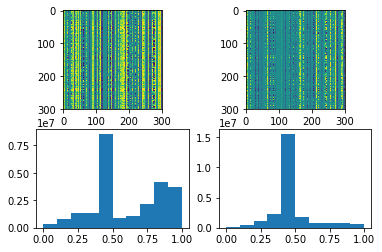

In [7]:
fig, axes = plt.subplots(2,2)
axes[0,0].imshow(lng_gates[:300])
axes[0,1].imshow(vis_gates[:300])
axes[1,0].hist(lng_gates.ravel())
axes[1,1].hist(vis_gates.ravel())

In [138]:
def get_gate_norms(model, test_iter):
    lng_norms = []
    vis_norms = []
    with function.no_backprop_mode(), chainer.using_config('train', False):
            for i, batch in enumerate(test_iter):
                inputs = conv_f(batch, device)
                n_l, n_v = get_gate_norm(model, inputs)
                n_l.to_cpu()
                n_v.to_cpu()

                lng_norms.append(n_l.data)
                vis_norms.append(n_v.data)

    lng_norms = np.hstack(lng_norms)
    vis_norms = np.hstack(vis_norms)
    return lng_norms, vis_norms

def get_gate_means(model, test_iter):
    lng_norms = []
    vis_norms = []
    with function.no_backprop_mode(), chainer.using_config('train', False):
            for i, batch in enumerate(test_iter):
                inputs = conv_f(batch, device)
                n_l, n_v = get_gate_mean(model, inputs)
                n_l.to_cpu()
                n_v.to_cpu()

                lng_norms.append(n_l.data)
                vis_norms.append(n_v.data)

    lng_norms = np.hstack(lng_norms)
    vis_norms = np.hstack(vis_norms)
    return lng_norms, vis_norms

In [38]:
def lang_iou(x, y):
    x = set(x.split('+'))
    y = set(y.split('+'))
    inter = x.intersection(y)
    union = x.union(y)
    iou = len(inter) / len(union)
    return iou

df = data.pair_data.copy()
df['p_ious'] = [lang_iou(r['phrase1'], r['phrase2']) for _, r in df.iterrows()]
df['ytrue'] = df.ytrue
df['lng_gate'] = lng_norms
df['vis_gate'] = vis_norms

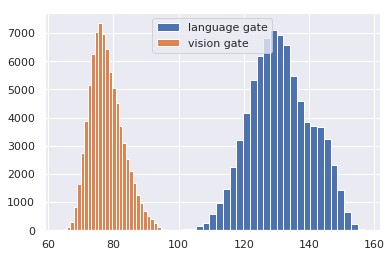

In [128]:
l = df['lng_gate'].values
v = df['vis_gate'].values

plt.hist(l, bins=30, label='language gate')
plt.hist(v, bins=30, label='vision gate')
plt.legend()

In [76]:
ddpn_bbox = DDPNBBoxDataset('test').df

In [74]:
def get_most_similar(q, targ):
    best_d = np.inf
    for x in targ:
        d = edit_distance(q, x)
        if d < best_d:
            best_d = d
            res = x
        if best_d == 0:
            break
    return res

def lget_bbox(df, img_id, phr):
    item = df[(df.image == img_id) & (df.phrase == phr)]
    if len(item) == 0:
        phrases = df[(df.image == img_id)].phrase.tolist()
        phr_ = get_most_similar(phr, phrases)
        item = df[(df.image == img_id) & (df.phrase == phr_)]
        
    roi = item[['ymin', 'xmin', 'ymax', 'xmax']].values
    return roi

Text(0.5,1,'mask | Two people')

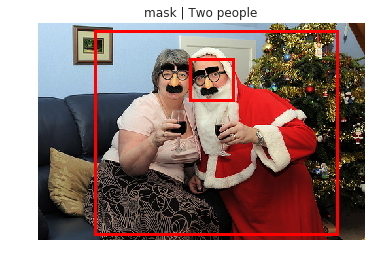

In [123]:
i = np.random.randint(len(df[df.vis_gate < 70]))
item = df[df.vis_gate < 70].iloc[i]

img, p1, p2 = item.image, item.original_phrase1, item.original_phrase2

b1 = lget_bbox(ddpn_bbox, img, p1)
b2 = lget_bbox(ddpn_bbox, img, p2)

im = plt.imread(img_root+'%i.jpg'%img)
vis_bbox(im.transpose(2, 0, 1), np.vstack([b1, b2]))
plt.axis('off')
plt.title(p1+' | '+p2)

Text(0.5,1,'a blue lake | wakeboard')

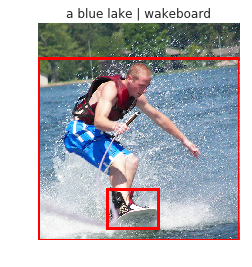

In [95]:
i = np.random.randint(len(df[df.vis_gate > 90]))
item = df[df.vis_gate > 90].iloc[i]

img, p1, p2 = item.image, item.original_phrase1, item.original_phrase2

b1 = lget_bbox(ddpn_bbox, img, p1)
b2 = lget_bbox(ddpn_bbox, img, p2)

im = plt.imread(img_root+'%i.jpg'%img)
vis_bbox(im.transpose(2, 0, 1), np.vstack([b1, b2]))
plt.axis('off')
plt.title(p1+' | '+p2)

Text(0.5,1,'the cereal selection | the grocery aisle of a store')

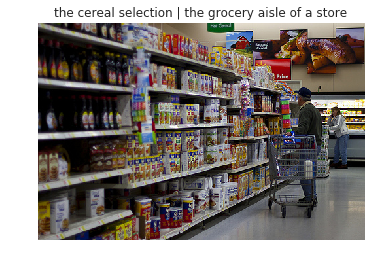

In [60]:
i = np.random.randint(len(df[df.lng_gate > 140]))
item = df[df.lng_gate > 140].iloc[i]

img, p1, p2 = item.image, item.original_phrase1, item.original_phrase2
plt.imshow(plt.imread(img_root+'%i.jpg'%img))
plt.axis('off')
plt.title(p1+' | '+p2)

test data: 81285 pairs
done


test data: 81285 pairs
done
lng gate: mean 0.62, std 0.02
vis gate: mean 0.49, std 0.01


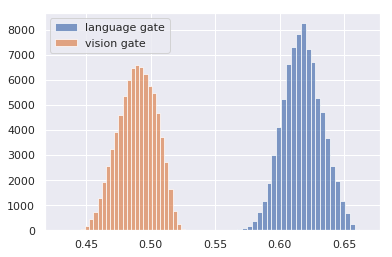

In [139]:
# multimodal gate
data = DDPNDataset('test', san_check=False)
test_iter = SerialIterator(data, batch_size=1000, repeat=False, shuffle=True)
model = Switching_iParaphraseNet(gate_mode='mult')
chainer.serializers.load_npz('bo_out/vis+lng+ddpn+mult/18-20181108-015934/model', model)

device = 0
if device is not None:
    chainer.cuda.get_device_from_id(device).use()
    model.to_gpu()

lng_norms, vis_norms = get_gate_means(model, test_iter)
plt.hist(lng_norms, bins=30, label='language gate', alpha=.7)
plt.hist(vis_norms, bins=30, label='vision gate', alpha=.7)
plt.legend()

print('lng gate: mean %.2f, std %.2f' % (lng_norms.mean(), lng_norms.std()))
print('vis gate: mean %.2f, std %.2f' % (vis_norms.mean(), vis_norms.std()))

test data: 81285 pairs
done
lng gate: mean 0.52, std 0.01
vis gate: mean 0.41, std 0.03


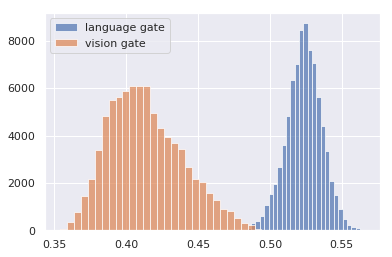

In [140]:
# visual gate
data = DDPNDataset('test', san_check=False)
test_iter = SerialIterator(data, batch_size=1000, repeat=False, shuffle=True)
model = Switching_iParaphraseNet(gate_mode='vis')
chainer.serializers.load_npz('bo_out/vis+lng+ddpn+vis/21-20181108-033749/model', model)

device = 0
if device is not None:
    chainer.cuda.get_device_from_id(device).use()
    model.to_gpu()

lng_norms, vis_norms = get_gate_means(model, test_iter)
plt.hist(lng_norms, bins=30, label='language gate', alpha=.7)
plt.hist(vis_norms, bins=30, label='vision gate', alpha=.7)
plt.legend()

print('lng gate: mean %.2f, std %.2f' % (lng_norms.mean(), lng_norms.std()))
print('vis gate: mean %.2f, std %.2f' % (vis_norms.mean(), vis_norms.std()))

test data: 81285 pairs
done
lng gate: mean 0.60, std 0.02
vis gate: mean 0.45, std 0.03


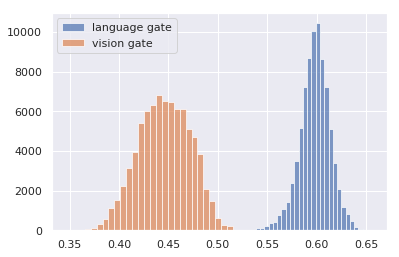

In [141]:
# langauge gate
data = DDPNDataset('test', san_check=False)
test_iter = SerialIterator(data, batch_size=1000, repeat=False, shuffle=True)
model = Switching_iParaphraseNet(gate_mode='lng')
chainer.serializers.load_npz('bo_out/vis+lng+ddpn+lng/15-20181108-003946/model', model)

device = 0
if device is not None:
    chainer.cuda.get_device_from_id(device).use()
    model.to_gpu()

lng_norms, vis_norms = get_gate_means(model, test_iter)
plt.hist(lng_norms, bins=30, label='language gate', alpha=.7)
plt.hist(vis_norms, bins=30, label='vision gate', alpha=.7)
plt.legend()

print('lng gate: mean %.2f, std %.2f' % (lng_norms.mean(), lng_norms.std()))
print('vis gate: mean %.2f, std %.2f' % (vis_norms.mean(), vis_norms.std()))